# Scope of this workbook

Here, we want to actually model the whole thing for different datasets. 

In [1]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

import joblib

#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Processed Dataset

In [2]:
full_df = pd.read_pickle('../data/finalized/full_df.pkl')

#full_df.describe()

In [3]:
full_df.head()

,ac_registration_x,Ac Type Code,sched_trans_time,flt_event_number,leg,block_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,minute_of_day_dep,sched_groundtime_before,Crewchange_before,rows_to_drop_grounddelay
0,ECLBAX,321,0,1,New Jessica-East Carmen,-9.0,5,3,6,205,95.0,first flt of day,0
1,ECLBAX,321,60,2,East Carmen-South Nathaniel,-9.0,5,8,10,500,95.0,both,0
2,ECLBAX,321,75,3,South Nathaniel-East Carmen,-14.0,5,11,14,710,75.0,no change,0
3,ECLBAX,321,70,4,East Carmen-Joneshaven,-11.0,5,15,17,935,80.0,both,0
4,ECLBAX,321,50,5,Joneshaven-East Carmen,-10.0,5,17,19,1070,50.0,no change,1


#temp 
import math 

full_df['minute_of_day_dep_norm'] = 2* math.pi * full_df['minute_of_day_dep'] / full_df['minute_of_day_dep'].max()
full_df['cos_minute'] = np.cos(full_df['minute_of_day_dep_norm'])
full_df['sin_minute'] = np.sin(full_df['minute_of_day_dep_norm'])
full_df['sin*cos'] = full_df['sin_minute']*full_df['cos_minute']
full_df.drop(['minute_of_day_dep_norm','cos_minute','sin_minute'], axis=1, inplace=True)

## Encoding & Train/Test split

In [4]:
# Creating dummy variables for all categorical variables
# Note: Onehotencoder is the better solution, however for simplicity let's use pandas for the moment

# Get object columns
full_df_objectcolumns = full_df.select_dtypes(include = ['object', 'category'])
varlist = full_df_objectcolumns.columns.values.tolist()

# get dummies
full_df_encoded = pd.get_dummies(full_df, columns = varlist, drop_first = True)

full_df_encoded.shape

(8422, 329)

In [5]:
# We split the forecast in two different forecasts - one for ground delay and one for block delay
# Note: this is coming from the previous approach where I tried to separate in between ground delay and block delay. block delay is now the overal delay at landing. 

# dropping the ground delay filter row
full_df_encoded_blockdelay = full_df_encoded.drop(['rows_to_drop_grounddelay'], axis = 1)
X_train_blockdelay_encoded, X_test_blockdelay_encoded, y_train_blockdelay_encoded, y_test_blockdelay_encoded = train_test_split(
    full_df_encoded_blockdelay.drop(['block_delay'], axis = 1), full_df_encoded_blockdelay['block_delay'], test_size=0.33, random_state=42)

# Filtering out rows which are skewing ground delay prediction
#full_df_encoded_grounddelay = full_df_encoded[full_df_encoded['rows_to_drop_grounddelay'] == 0]

#X_train_grounddelay_encoded, X_test_grounddelay_encoded, y_train_grounddelay_encoded, y_test_grounddelay_encoded = train_test_split(
#    full_df_encoded_grounddelay.drop(['ground_delay'], axis = 1), full_df_encoded_grounddelay['ground_delay'], test_size=0.33, random_state=42)



## Linear Regression (Base Model)


In [6]:
# Blocktime
lr_block = LinearRegression()

lr_block.fit(X_train_blockdelay_encoded, y_train_blockdelay_encoded)
lr_block.predict(X_test_blockdelay_encoded)

# Groundtime
#lr_ground = LinearRegression()

#lr_ground.fit(X_train_grounddelay_encoded, y_train_grounddelay_encoded)
#lr_ground.predict(X_test_grounddelay_encoded)

array([ -4.97700882,  -5.18752289, -11.83729553, ...,  -9.68889999,
        -6.59990692,  -4.00579453])

In [7]:
# Blocktime
r2_blockdelay = lr_block.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, lr_block.predict(X_test_blockdelay_encoded)))
print("The r^2 for Block delay is " + str(round(r2_blockdelay,4)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")
print("\n")

# Groundtime
#r2_grounddelay = lr_ground.score(X_test_grounddelay_encoded, y_test_grounddelay_encoded)
#rmse_grounddelay = np.sqrt(mean_squared_error(y_test_grounddelay_encoded, lr_ground.predict(X_test_grounddelay_encoded)))
#print("The r^2 for Ground delay is " + str(round(r2_grounddelay,4)))
#print("The RMSE for Ground delay is " + str(round(rmse_grounddelay,2)) + " minutes.")

The r^2 for Block delay is -3567084.6423
The RMSE for Block delay is 13046.61 minutes.




# Baseline Model (Dummy)

In [8]:
dummy = DummyRegressor()
dummy.fit(X_train_blockdelay_encoded, y_train_blockdelay_encoded)
dummy.predict(X_test_blockdelay_encoded)

array([-4.96650124, -4.96650124, -4.96650124, ..., -4.96650124,
       -4.96650124, -4.96650124])

In [9]:

r2_blockdelay = dummy.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, dummy.predict(X_test_blockdelay_encoded)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")

The RMSE for Block delay is 6.91 minutes.


## Setup of Modelling

In [10]:
# Imports 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [11]:
%%time
# Initialize estimators

#reg1 = LinearRegression()
reg2 = Ridge()
reg3 = Lasso()
reg4 = GradientBoostingRegressor()
reg5 = ElasticNet()

# Initialize hyperparameters for each dictionary
#param1 = {}

param2 = {}
param2['regressor__alpha'] = [x for x in np.linspace(0,10,num = 51)]
param2['regressor'] = [reg2]

param3 = {}
param3['regressor__alpha'] = [x for x in np.linspace(0,10,num = 51)]
param3['regressor'] = [reg3]

param4 = {}
param4['regressor__n_estimators'] = [55,56,57,58] #[10,50,100,150,250]#[10,50,100,150,200,250]
param4['regressor__max_depth'] = [12,13,14]#,18,20]#,18]#,22] #[2,3,6,8,10,12,18] #[2,3,4,6,8,10,12,15,18]
param4['regressor__max_leaf_nodes'] = [28,29,30]#[6,8,12,15,19,25]#,18] #[6,8,12,None] #[6,8,12,15,19,25,None]
param4['regressor'] = [reg4]

param5 = {}
param5['regressor__alpha'] = [x for x in np.linspace(0.001,10,num = 10)]
param5['regressor__l1_ratio'] = [x for x in np.linspace(0,1,num = 10)]
param5['regressor__max_iter'] = [2000]
param5['regressor'] = [reg5]


# Create Pipeline
pipeline = Pipeline([('regressor', reg2)])
params = [param2, param3, param5, param4]

# Train grid search model
gs_block = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1).fit(X_train_blockdelay_encoded,y_train_blockdelay_encoded)
#gs_ground = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1).fit(X_train_grounddelay_encoded,y_train_grounddelay_encoded)

print(gs_block.best_estimator_, gs_block.best_params_)
#print(gs_ground.best_estimator_, gs_ground.best_params_)

#Evaluation
# Blocktime
r2_blockdelay = gs_block.best_estimator_.score(X_test_blockdelay_encoded, y_test_blockdelay_encoded)
rmse_blockdelay = np.sqrt(mean_squared_error(y_test_blockdelay_encoded, gs_block.best_estimator_.predict(X_test_blockdelay_encoded)))
print("The r^2 for Block delay is " + str(round(r2_blockdelay,4)))
print("The RMSE for Block delay is " + str(round(rmse_blockdelay,2)) + " minutes.")
print("\n")

# Groundtime
#r2_grounddelay = gs_ground.best_estimator_.score(X_test_grounddelay_encoded, y_test_grounddelay_encoded)
#rmse_grounddelay = np.sqrt(mean_squared_error(y_test_grounddelay_encoded, gs_ground.best_estimator_.predict(X_test_grounddelay_encoded)))
#print("The r^2 for Ground delay is " + str(round(r2_grounddelay,4)))
#print("The RMSE for Ground delay is " + str(round(rmse_grounddelay,2)) + " minutes.")





Fitting 3 folds for each of 238 candidates, totalling 714 fits
Pipeline(steps=[('regressor',
                 GradientBoostingRegressor(max_depth=13, max_leaf_nodes=30,
                                           n_estimators=55))]) {'regressor': GradientBoostingRegressor(max_depth=13, max_leaf_nodes=30, n_estimators=55), 'regressor__max_depth': 13, 'regressor__max_leaf_nodes': 30, 'regressor__n_estimators': 55}
The r^2 for Block delay is 0.2337
The RMSE for Block delay is 6.05 minutes.


CPU times: total: 5.66 s
Wall time: 1min 40s


In [12]:
# Having a look at the results
pd.set_option('display.float_format', lambda x: '%.3f' % x)
results = pd.DataFrame(gs_block.cv_results_).sort_values(by='rank_test_score')
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__alpha,param_regressor__l1_ratio,param_regressor__max_iter,param_regressor__max_depth,param_regressor__max_leaf_nodes,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
222,3.877,0.110,0.015,0.002,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,13,30,55,{'regressor': GradientBoostingRegressor(max_de...,-6.115,-5.985,-6.309,-6.136,0.133,1
203,7.015,0.190,0.024,0.006,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,12,28,56,{'regressor': GradientBoostingRegressor(max_de...,-6.102,-5.998,-6.311,-6.137,0.130,2
230,3.985,0.192,0.015,0.000,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,14,29,55,{'regressor': GradientBoostingRegressor(max_de...,-6.107,-5.974,-6.334,-6.138,0.149,3
231,4.000,0.166,0.016,0.001,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,14,29,56,{'regressor': GradientBoostingRegressor(max_de...,-6.114,-5.973,-6.330,-6.139,0.147,4
232,4.010,0.067,0.016,0.001,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,14,29,57,{'regressor': GradientBoostingRegressor(max_de...,-6.111,-5.975,-6.330,-6.139,0.146,5
223,3.986,0.095,0.015,0.000,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,13,30,56,{'regressor': GradientBoostingRegressor(max_de...,-6.116,-5.987,-6.314,-6.139,0.134,6
202,6.692,0.305,0.029,0.006,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,12,28,55,{'regressor': GradientBoostingRegressor(max_de...,-6.108,-5.992,-6.318,-6.140,0.135,7
204,5.697,0.150,0.014,0.001,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,12,28,57,{'regressor': GradientBoostingRegressor(max_de...,-6.106,-5.999,-6.315,-6.140,0.131,8
205,5.550,0.170,0.016,0.002,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,12,28,58,{'regressor': GradientBoostingRegressor(max_de...,-6.106,-5.997,-6.318,-6.140,0.133,9
233,4.232,0.105,0.016,0.005,"GradientBoostingRegressor(max_depth=13, max_le...",NaN,NaN,NaN,14,29,58,{'regressor': GradientBoostingRegressor(max_de...,-6.114,-5.969,-6.338,-6.140,0.152,10


In [13]:
# Evaluation per flight event number

full_df.head()

RMSEs = []
for i in range(1,11):
    indices = X_test_blockdelay_encoded[X_test_blockdelay_encoded['flt_event_number']==i].index
    rmse_blockdelay_flt_event = np.sqrt(
        mean_squared_error(y_test_blockdelay_encoded.loc[indices], 
        gs_block.best_estimator_.predict(X_test_blockdelay_encoded.loc[indices]))
        )
    n = X_test_blockdelay_encoded.loc[indices].shape[0]
    print('RMSE for Landing Delay for flight ', i , ' is ', round(rmse_blockdelay_flt_event,2), ' minutes, using ', n, ' test observations')
    
    RMSEs.append(rmse_blockdelay_flt_event)

gs_block.best_estimator_

RMSE for Landing Delay for flight  1  is  5.98  minutes, using  537  test observations
RMSE for Landing Delay for flight  2  is  5.94  minutes, using  519  test observations
RMSE for Landing Delay for flight  3  is  5.94  minutes, using  488  test observations
RMSE for Landing Delay for flight  4  is  6.22  minutes, using  418  test observations
RMSE for Landing Delay for flight  5  is  5.89  minutes, using  336  test observations
RMSE for Landing Delay for flight  6  is  6.36  minutes, using  277  test observations
RMSE for Landing Delay for flight  7  is  6.59  minutes, using  131  test observations
RMSE for Landing Delay for flight  8  is  5.5  minutes, using  63  test observations
RMSE for Landing Delay for flight  9  is  3.0  minutes, using  8  test observations
RMSE for Landing Delay for flight  10  is  8.74  minutes, using  3  test observations


Pipeline(steps=[('regressor',
                 GradientBoostingRegressor(max_depth=13, max_leaf_nodes=30,
                                           n_estimators=55))])

0.11485780656126562

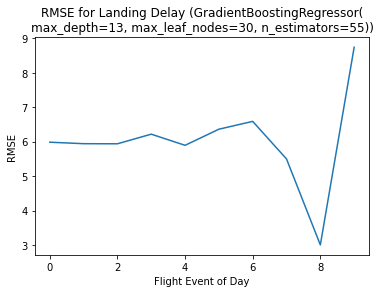

In [14]:
# Plotting the difference of RSMEs over flight events
plt.plot(RMSEs)
plt.title('RMSE for Landing Delay (GradientBoostingRegressor(\nmax_depth=13, max_leaf_nodes=30, n_estimators=55))')
plt.xlabel('Flight Event of Day')
plt.ylabel('RMSE')

# Calculating the standard deviation over flight events per day
np.std(RMSEs[:5])

# Evaluation of Best Model

In [15]:
# Attention: Features with many unique values get assigned higher importance (e.g., leg)

feature_importances = gs_block.best_estimator_.steps[0][1].feature_importances_

d = {'Features': X_train_blockdelay_encoded.columns, 'Importance': feature_importances}
eval = pd.DataFrame(data = d).sort_values(by = 'Importance', ascending = False)     
eval.head(50)

,Features,Importance
78,Ac Type Code_DH4,0.154
5,minute_of_day_dep,0.104
79,Ac Type Code_DHX,0.048
247,leg_Lake Lawrencechester-Lake Richardberg,0.035
212,leg_East Latashaview-East Carmen,0.032
2,day_of_week,0.027
4,hour_of_day_arr,0.026
6,sched_groundtime_before,0.026
80,Ac Type Code_E95,0.022
0,sched_trans_time,0.020


# Export of Model

In [16]:
model = gs_block.best_estimator_
joblib.dump(model, '../models/best_estimator.pkl' )

['../models/best_estimator.pkl']